In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import pandas as pd

sys.path.append("../../ndsvae/")
import ndsvae as ndsv

sys.path.append("../")
import util
import plotutils as pu

%matplotlib inline

In [2]:
config = "ns_3_mreg_3_msub_0_nf_32"
conn = "linw"
preproc = "dicer"
modelname = "AB"

ds = ndsv.Dataset.from_file(f"../run/hcp/hcp100_{conn}_{preproc}/dataset.npz")
run = util.select_run_fc(f"hcp100_{conn}_{preproc}", modelname, config, [0,1], "hcp")
direc = f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}"
params = util.load_params(os.path.join(direc, "parameters"), np.r_[:100])

model = util.get_model(modelname, config, ds)
model.load_weights(f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}/fit/model")

2022-08-11 14:37:14.648765: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-11 14:37:14.650002: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
isub = 45
irand = 3

nsub, nreg, _, nt = ds.y.shape
fixed_points = np.load("res/subj_fp.npz")
df = pd.read_csv("res/subj_fp.csv")
df[(df.isub == isub) & (df.irand == irand)]

,Unnamed: 0,isub,irand,n,ifp,stable
190,190,45,3,0,190,True
191,191,45,3,1,191,True
192,192,45,3,2,192,False


In [4]:
# Get the fixed points

xf1 = fixed_points['fixed_points'][190]
xf2 = fixed_points['fixed_points'][191]
xf3 = fixed_points['fixed_points'][192]
iregs = np.argsort(-np.linalg.norm(xf1-xf2, axis=1))[:2]

In [5]:
ntd = int(nt//3)
nsamples = 1

# Multistable subject
thetareg = np.zeros((1, nreg, model.ns, 2))
thetareg[:,:,:,0] = fixed_points['thetareg'][isub,irand]
sims = model.simulate_subjects(ds.w[[isub]], ntd+20*nt, thetareg=thetareg, thetasub=None,
                               us=None, n=nsamples)
x = sims.x[0,0,:,:,ntd:]

## Figure

In [6]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

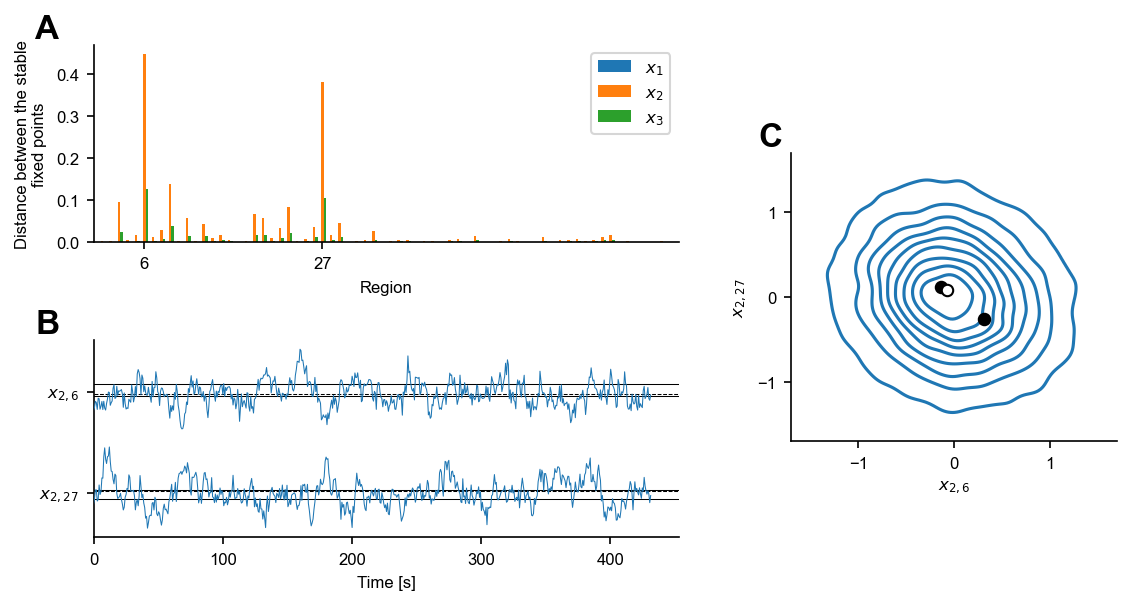

In [10]:
fig = plt.figure(figsize=(7.5, 4), dpi=150)

gs1 = GridSpec(nrows=2, ncols=1, left=0.08, bottom=0.1, right=0.6, hspace=0.5, top=0.92)
gs2 = GridSpec(nrows=1, ncols=1, left=0.7, right=0.99, bottom=0.26, top=0.74)

# Distance of fixed points
ax = plt.subplot(gs1[0])
for i in range(model.ns):
    plt.bar(np.r_[:nreg]-0.3+i*0.3, np.abs(xf1-xf2)[:,i], width=0.3, label=f"$x_{i+1}$")
    
plt.legend()
plt.xlim(0, 69)
plt.xlabel("Region")
plt.ylabel("Distance between the stable\nfixed points")
plt.xticks(iregs)
pu.bottomleft_spines(ax)
                     

# What to plot    
i1 = iregs[0]
i2 = iregs[1]
k = 1    
    
# Plot simulated time series
ntp = 600

ax = plt.subplot(gs1[1])
for i, ireg in enumerate(reversed(iregs)):
    plt.plot(0.72*np.r_[:ntp], x[ireg,k,0:ntp]+4*i, lw=0.5, color='tab:blue', zorder=10)
    
    plt.axhline(xf1[ireg,k]+4*i, color='k', lw=0.5, ls='-')
    plt.axhline(xf2[ireg,k]+4*i, color='k', lw=0.5, ls='-')
    plt.axhline(xf3[ireg,k]+4*i, color='k', lw=0.5, ls='--')
    
    
plt.yticks([0,4], [f"$x_{{{k+1},{i2}}}$", f"$x_{{{k+1},{i1}}}$"])
pu.bottomleft_spines(ax)
plt.xlim(left=0.)
plt.xlabel("Time [s]")

# KDE plot
ax = plt.subplot(gs2[0])
sns.kdeplot(x=x[i1,k,:], y=x[i2,k,:], fill=False)

plt.scatter([xf1[i1,k], xf2[i1,k]], [xf1[i2,k], xf2[i2,k]], color='k', ec='k', lw=1, s=30, zorder=10)
plt.scatter([xf3[i1,k]], [xf3[i2,k]], color='w', ec='k', lw=1, s=30, zorder=10)

plt.xlabel(f"$x_{{{k+1},{i1}}}$")
plt.ylabel(f"$x_{{{k+1},{i2}}}$")
plt.xlim(-1.7, 1.7)
plt.ylim(-1.7, 1.7)
plt.xticks([-1,0,1])
plt.yticks([-1,0,1])
pu.bottomleft_spines(ax)

# bg = pu.Background(visible=True)
pu.add_panel_labels(fig=fig, fontsize=16, xs=-0.1, ys=1.0)
plt.savefig("img/Fig_MultistableSubject.pdf")